In [ ]:
 !pip install flake8 pycodestyle_magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 341 kB/s 
     |████████████████████████████████| 66 kB 3.8 MB/s 
     |████████████████████████████████| 41 kB 400 kB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.0.0
    Uninstalling importlib-metadata-5.0.0:
      Successfully uninstalled importlib-metadata-5.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.


In [1]:
#%load_ext pycodestyle_magic

%load_ext autoreload
#%load_ext pycodestyle_magic

In [2]:
#%flake8_on
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/KNN

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/KNN


In [ ]:
from sklearn import datasets
import numpy as np
import pandas
from sklearn.model_selection import train_test_split
from nearest_neighbors import KNNClassifier
import time
from tabulate import tabulate
from numpy.random import default_rng
from cross_validation import kfold
from cross_validation import knn_cross_val_score
import pandas as pd

import skimage.io
import skimage.color
import skimage.transform
import scipy.ndimage
import cv2 as cv
from cv2 import GaussianBlur
from cv2 import erode, dilate, morphologyEx, morphologyEx
import gc
from cv2 import MORPH_OPEN, MORPH_CLOSE


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import Normalize
import numpy as np
from cross_validation import knn_cross_val_score_aug
#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

# Новый раздел

In [ ]:
data_targets = datasets.fetch_openml("mnist_784")

In [ ]:
X = data_targets.data.to_numpy()
y = data_targets.target.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000, shuffle=False)

1. Исследуйте, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях и
почему.
Измерьте для каждого алгоритма поиска ('kd_tree', 'ball_tree', 'brute' и 'my_own') время нахождения 5
ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмноже-
ство признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков
выбирается один раз для всех объектов, случайно). Проверьте все алгоритмы поиска ближайших соседей,
указанные в спецификации к заданию.  
#Замечание. 
Для оценки времени долго работающих функций можно пользоваться либо функциями из
модуля time , либо magic-командой %time , которая запускает код лишь один раз.

In [ ]:
sampling_size_list = (10, 20, 100)
strategy_list = ('my_own', 'kd_tree', 'ball_tree', 'brute')
table1 = []
for size in sampling_size_list:
    rng = default_rng()
    indexes = rng.choice(X.shape[1], size = size, replace=False)
    for strategy in strategy_list:
        numb_cl = KNNClassifier(k=5, strategy=strategy)
        numb_cl.fit(X_train[:, indexes], y_train)
        time_start = time.time()
        numb_cl.find_kneighbors(X_test[:, indexes], return_distance=False)
        time_end = time.time()
        table1.append([size, 
                      strategy,
                      f'{(time_end - time_start):.{4}f}'
                      ])

Нарисуем таблицу результа работы алгоритма поиска k соседей (k=5) для
простространства признаков размtрности 10, 20, 100 и для стратегий
'my_own', 'kd_tree', 'ball_tree', 'brute'

In [ ]:
headers = ['size', 'strategy', 'time (s)']
print(tabulate(table1, headers, tablefmt="grid", numalign="left",
               floatfmt=".4f"))

+--------+------------+------------+
| size   | strategy   | time (s)   |
+========+============+============+
| 10     | my_own     | 11.7944    |
+--------+------------+------------+
| 10     | kd_tree    | 1.1963     |
+--------+------------+------------+
| 10     | ball_tree  | 2.7306     |
+--------+------------+------------+
| 10     | brute      | 9.7170     |
+--------+------------+------------+
| 20     | my_own     | 11.5678    |
+--------+------------+------------+
| 20     | kd_tree    | 6.1639     |
+--------+------------+------------+
| 20     | ball_tree  | 15.8625    |
+--------+------------+------------+
| 20     | brute      | 11.1233    |
+--------+------------+------------+
| 100    | my_own     | 14.3582    |
+--------+------------+------------+
| 100    | kd_tree    | 150.3574   |
+--------+------------+------------+
| 100    | ball_tree  | 136.2855   |
+--------+------------+------------+
| 100    | brute      | 12.7173    |
+--------+------------+------------+


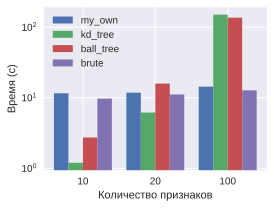

In [ ]:
columns = [10, 20, 100]
index = np.arange(len(columns))
plt.figure(figsize=(4, 3))
#plt.title("Время работы алгоритма поиска \nближайших соседей от"
 #            "количества признаков")

plt.xlabel("Количество признаков")
plt.ylabel("Время (с)")
plt.xticks(index + 0.3, columns)
plt.yscale('log')
strategy_list = ('my_own', 'kd_tree', 'ball_tree', 'brute')
for strategy in strategy_list:
    time = []
    for record in table1:
        if record[1] == strategy:
            time.append(float(record[2]))
    plt.bar(index , sorted(time), width=0.2, label=strategy)
    plt.legend()
    index = index + 0.2
plt.savefig("times_strategies.pdf", bbox_inches = 'tight') 

2. Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и время
работы k ближайших соседей в зависимости от следующих факторов:  
(a) k от 1 до 10 (только влияние на точность).  
(b) Используется евклидова или косинусная метрика.
Дайте ответ на следующие вопросы:  
(a) Какая метрика лучше себя показала в экспериментах? Можете ли вы объяснить, почему?  
(b) Есть ли на графике зависимости точности от количество соседей выбросы, резкие падения/повышения
качества для одного значения k по сравнению с соседними? Если да, предположите причину появления
этих выбросов.

In [ ]:
table2 = []
for metric in ['euclidean', 'cosine']:
    for k, score in knn_cross_val_score(
            X_train, y_train, 
            k_list=list(range(1, 11, 1)),
            cv=kfold(n=len(X_train), n_folds=3),
            metric=metric,
            strategy='brute',
            weights=False).items():
        table2.append([metric, k, score])

In [ ]:
columns = ['metric', 'n_neighbors', 'scores']
score_frame2 = pd.DataFrame(table2, columns=columns)
score_frame2['scores'] = score_frame2['scores'].apply(lambda a: np.mean(a))
score_frame2.iloc[score_frame2.groupby('metric')['scores'].idxmax()]

,metric,n_neighbors,scores
12,cosine,3,0.972033
2,euclidean,3,0.968317


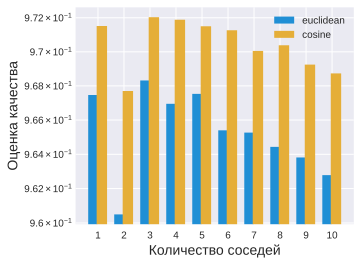

In [ ]:
euclidean_scores = score_frame2[score_frame2.metric.isin(['euclidean'])]
cosine_scores = score_frame2[score_frame2.metric.isin(['cosine'])]
columns = np.arange(1, 11, 1)
index = np.arange(len(columns))
plt.figure(figsize = (5, 4))
plt.yscale('log')
plt.xticks(index + 0.2, columns)
plt.grid(True, which='both')
#plt.title("Зависимость оценки качества, полученной с \nпомощью кросс-валидации,"
#  "от количества соседей", fontsize=16)
plt.ylabel("Оценка качества", fontsize=14)
plt.xlabel("Количество соседей", fontsize=14)
plt.bar(index, euclidean_scores['scores'], width = 0.35,
        label='euclidean', color='#208fd5')
plt.bar(index + 0.35, cosine_scores['scores'],
        label='cosine', width = 0.4, color='#e5ae38')
plt.legend()
plt.savefig('score_n_neigh.pdf', bbox_inches='tight')

In [ ]:
"""ean_scores = np.empty((2, 10))
for index, metric in enumerate(scores):
    for k, score in scores[metric].items():
        mean_scores[index, k - 1] = np.mean(score)
table = [['euclidean', np.max(mean_scores[0]), np.argmax(mean_scores[0]) + 1],
     ['cosine', np.max(mean_scores[1]), np.argmax(mean_scores[1]) + 1]]
headers = ['metric', 'maximum of\nmean_score', 'best k']
print(tabulate(table, headers, tablefmt="grid", numalign="left",
               floatfmt=(".0f",".4f")))"""

'ean_scores = np.empty((2, 10))\nfor index, metric in enumerate(scores):\n    for k, score in scores[metric].items():\n        mean_scores[index, k - 1] = np.mean(score)\ntable = [[\'euclidean\', np.max(mean_scores[0]), np.argmax(mean_scores[0]) + 1],\n     [\'cosine\', np.max(mean_scores[1]), np.argmax(mean_scores[1]) + 1]]\nheaders = [\'metric\', \'maximum of\nmean_score\', \'best k\']\nprint(tabulate(table, headers, tablefmt="grid", numalign="left",\n               floatfmt=(".0f",".4f")))'

3. Сравните взвешенный метод k ближайших соседей, где голос объекта равен $1/(distance+\epsilon)$, где $\epsilon -10^{−5}$,
с методом без весов при тех же фолдах и параметрах.

In [ ]:
table3 = []
for metric in ['euclidean', 'cosine']:
    for weights in [True, False]:
        for k, score in knn_cross_val_score(
                X_train, y_train, 
                k_list=list(range(1, 11, 1)),
                cv=kfold(n=len(X_train), n_folds=3),
                metric=metric,
                strategy='my_own',
                weights=weights).items():
            table3.append([metric, weights, k, score])

In [ ]:
columns = ['metric', 'weights', 'n_neighbors', 'scores']
score_frame3 = pd.DataFrame(data=table3, columns=columns)
score_frame3['scores'] = score_frame3['scores'].apply(lambda a : np.mean(a))
score_frame3
euclidean_score3 = score_frame3[score_frame3.metric.isin(['euclidean'])]
cosine_score3 = score_frame3[score_frame3.metric.isin(['cosine'])]

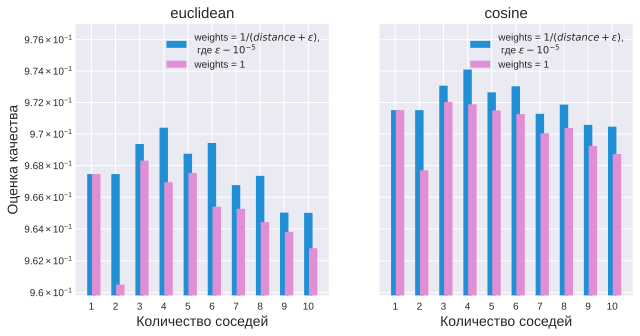

In [ ]:
columns = [i for i in range(1, 11, 1)]
x_coo = np.arange(len(columns))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

ax1.set_yscale('log')
ax1.grid(True, which='both')
#plt.suptitle("Зависимость оценки качества, полученной с \nпомощью "
#               "кросс-валидации,от количества соседей", fontsize=16, y=1.05)
ax1.set_title('euclidean', fontsize=15)
ax1.set_xlabel('Количество соседей', fontsize=14)
ax1.set_ylabel('Оценка качества', fontsize=14)
ax1.bar(
    x_coo, 
    euclidean_score3[euclidean_score3.weights.isin([True])]['scores'], 
    width=0.35,
    label='weights = $1/(distance+\epsilon)$,\n где $\epsilon -10^{−5}$', 
    color='#208fd5'
)
ax1.set_xticks(x_coo)
ax1.set_xticklabels(columns)
ax1.bar(
    x_coo + 0.2, 
    euclidean_score3[euclidean_score3.weights.isin([False])]['scores'], 
    width=0.35,
    label='weights = 1', 
    color='#e08fd5'
)
ax1.legend()

ax2.grid(True, which='both')
ax2.set_yscale('log')
ax2.set_title('cosine', fontsize=15)
ax2.set_xlabel('Количество соседей', fontsize=14)
ax2.set_xticks(x_coo)
ax2.set_xticklabels(columns)
ax2.bar(
    x_coo, 
    cosine_score3[cosine_score3.weights.isin([True])]['scores'], 
    width=0.35,
    label='weights = $1/(distance+\epsilon)$,\n где $\epsilon -10^{−5}$', 
    color='#208fd5'
)
ax2.set_ylim(top=0.977)
ax2.bar(
    x_coo + 0.2, 
    cosine_score3[cosine_score3.weights.isin([False])]['scores'], 
    width=0.35,
    label='weights = 1', 
    color='#e08fd5'
)
ax2.legend()
fig.savefig('score_neigh_weights.pdf', bbox_inches='tight')

In [ ]:
f = lambda x: x - 10
ec_t_score = euclidean_score3[euclidean_score3.weights.isin([True])]['scores']
ec_f_score = \
    euclidean_score3[euclidean_score3.weights.isin([False])]['scores'].rename(f)
dec_per = 100 * ((1 - ec_t_score) / (1 - ec_f_score) - 1)
d = {'percentage_of_bad_ans_decrease': (dec_per )}
percentage_decrease = pd.DataFrame(d)
percentage_decrease = percentage_decrease.rename(lambda x: x + 1)

In [ ]:
percentage_decrease

,percentage_of_bad_ans_decrease
1,0.000000
2,-17.637131
3,-3.314045
4,-10.438729
5,-3.747433
6,-11.657033
7,-4.318618
8,-8.200562
9,-3.362506
10,-6.000896


In [ ]:
percentage_decrease.describe()

,percentage_of_bad_ans_decrease
count,10.000000
mean,-6.867695
std,5.190938
min,-17.637131
25%,-9.879187
50%,-5.159757
75%,-3.458738
max,0.000000


In [ ]:
f = lambda x: x - 10
c_t_score = cosine_score3[cosine_score3.weights.isin([True])]['scores']
c_f_score = \
    cosine_score3[cosine_score3.weights.isin([False])]['scores'].rename(f)
dec_per1 = 100 * ((1 - c_t_score) / (1 - c_f_score) - 1)
d = {'percentage_decrease': dec_per1}
percentage_decrease = pd.DataFrame(d)
percentage_decrease = percentage_decrease.rename(lambda x: x - 19)

In [ ]:
percentage_decrease

,percentage_decrease
1,0.000000
2,-11.816305
3,-3.694875
4,-7.883817
5,-4.035088
6,-6.148492
7,-4.117974
8,-5.008441
9,-4.336043
10,-5.543710


In [ ]:
percentage_decrease.describe()

,percentage_decrease
count,10.000000
mean,-5.258475
std,3.065548
min,-11.816305
25%,-5.997296
50%,-4.672242
75%,-4.055809
max,0.000000


In [ ]:
score_frame3.iloc[score_frame3[score_frame3['weights'] == False].groupby(
    'metric')['scores'].idxmax()]

,metric,weights,n_neighbors,scores
32,cosine,False,3,0.972033
12,euclidean,False,3,0.968317


In [ ]:
score_frame3.iloc[score_frame3[score_frame3['weights'] == True].groupby(
    'metric')['scores'].idxmax()]

,metric,weights,n_neighbors,scores
23,cosine,True,4,0.9741
3,euclidean,True,4,0.9704


In [ ]:
score_frame3.iloc[score_frame3.groupby('metric')['scores'].idxmax()]

,metric,weights,n_neighbors,scores
23,cosine,True,4,0.9741
3,euclidean,True,4,0.9704


4. Примените лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитайте точность. Сравните
с точностью по кросс-валидации. Сравните с указанной в интернете точностью лучших алгоритмов на
данной выборке. Выполните анализ ошибок. Для этого необходимо построить и проанализировать матрицу
ошибок (confusion matrix). Также визуализируйте несколько объектов из тестовой выборки, на которых
были допущены ошибки. Проанализируйте и указажите их общие черты.
###Замечание.
 Для построения матрицы можно воспользоваться функцией
sklearn.metrics.confusion_matrix . Для визуализации можно воспользоваться pyplot.subplot , и
pyplot.imshow с параметром cmap="Greys" . Также можно убрать оси координат при помощи команды
pyplot.axis("off")

In [ ]:
%%time
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(X_train, y_train)
prediction = numb_cl.predict(X_test)


CPU times: user 1min 12s, sys: 3.12 s, total: 1min 15s
Wall time: 46.6 s


In [ ]:
acc = np.sum((prediction == y_test)) / len(y_test)

In [ ]:
cv = knn_cross_val_score(
    X_train, y_train, [4],
    cv=kfold(len(X_train), 3),
    strategy='my_own',
    metric='cosine',
    weights=True 
)

KeyboardInterrupt: ignored

In [ ]:
print(f"accuracy {acc}")
print(f'cross_validation_accuracy {np.mean(cv[4])}')
from math import floor
print(floor(np.mean(cv[4]) * len(X_train)))
print(floor(acc * len(X_train)))
print(max(['accuracy', acc],
          ['cross_validation_accuracy', np.mean(cv[4])],
          key=lambda x: x[1]))

accuracy 0.9752
cross_validation_accuracy 0.9741
58446
58512
['accuracy', 0.9752]


In [ ]:
100 * ((1 - 0.9982) / (1 - 0.9752) - 1)

-92.74193548387089

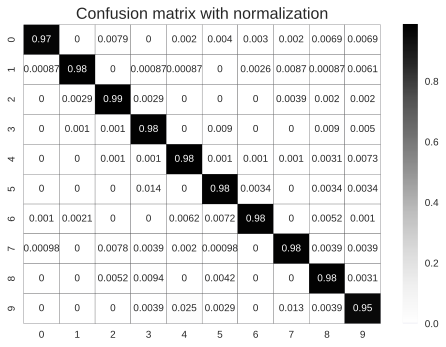

In [ ]:
conf_m = confusion_matrix(prediction, y_test, normalize='true')

title = 'Confusion matrix with normalization'
plt.title(title, fontsize=16)
plt.xlabel("True label")
plt.ylabel("Predicted label")
class_names = np.arange(0, 10)
sns.heatmap(conf_m, annot=True, fmt='.2g', linewidth=0.2, linecolor='black',
            cmap='Greys')


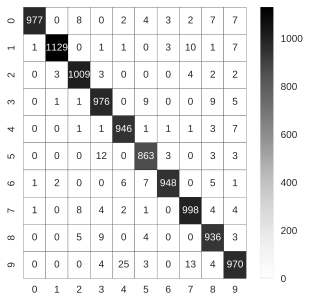

In [ ]:
conf_main = confusion_matrix(prediction, y_test)
plt.figure(figsize=(5, 5))
#plt.title(title, fontsize=16)
plt.xlabel("True label")
plt.ylabel("Predicted label")
class_names = np.arange(0, 10)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys")
plt.savefig("confusion_matrix_best_alg.pdf", bbox_inches='tight')

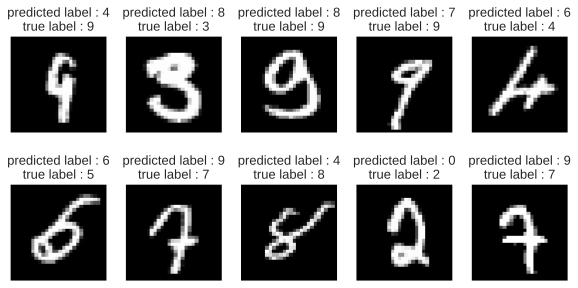

In [ ]:
rng = np.random.default_rng()
amount = 10
index = rng.permutation(range(len(X_test[prediction != y_test])))[:amount]

fig = plt.figure(figsize=(10, 5))
  

columns = 5
rows = amount // columns

for n in range(rows * columns):
    fig.add_subplot(rows, columns, n + 1)
    plt.imshow(X_test[prediction != y_test][index[n]].reshape((28,28)),
               cmap='gray')
    plt.axis('off')
    predict_l = prediction[prediction != y_test][index[n]]
    true_l = y_test[prediction != y_test][index[n]]
    plt.title(f'predicted label : {predict_l}\n'
              f'true label : {true_l}', fontsize=13)
plt.savefig("digits.pdf", bbox_inches='tight')


In [ ]:
import pickle

5. Выполните аугментацию обучающей выборки. Для этого нужно размножить ее с помощью поворотов,
смещений, морфологических операций и применений гауссовского фильтра. Разрешается использовать
библиотеки для работы с изображениями. Подберите по кросс-валидации с 3 фолдами параметры преобразований. Рассмотрите следующие параметры для преобразований и их комбинации:  
(a) Величина поворота: 5, 10, 15 (в каждую из двух сторон).  
(b) Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей).  
(c) Дисперсия фильтра Гаусса: 0.5, 1, 1.5.  
(d) Морфологические операции: эрозия, дилатация, открытие, закрытие с ядром 2 (https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html)
Проанализируйте, как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое
преобразование.   
###Замечание 1.
 Не обязательно хранить все обучающие выборки в процессе эксперимента. Достаточно вычислить ближайших соседей для каждой из выборок, а затем выбрать из них ближайших соседей.
###Замечание 2.
 Размер ядра фильтра Гаусса подобрать визуально: преобразование не должно сильно пор-
тить объекты
###Замечание по дизайну эксперимента.
 В этой части вам предлагается самим выбрать дизайн эксперимента. Перебор всевоpможных комбинаций преобразований может быть затруднительным, в то время как
жадный выбор преобразований уже даст улучшение в качестве.

#Найдем лучшее смещение

In [ ]:
shift_values = [1, 2, 3]
shift_directions = [-1, 1]
max = 0
best_shiftx = 0
best_shifty = 0


for direction in shift_directions:
    for shift in shift_values:
        shift_x = shift * direction
        shift_y = 0
        
        cv = knn_cross_val_score_aug(
                X_train, y_train, [4],
                [shift_x, shift_y], #args of aug
                cv=kfold(len(X_train), 3),
                score='accuracy',
                aug=scipy.ndimage.shift,
                strategy='brute',
                metric='cosine',
                weights=True 
        )
        print(f'({shift_x}, 0) {np.mean(cv[4])}')

(-1, 0) 0.9753333333333333
(-2, 0) 0.9745166666666667
(-3, 0) 0.9742333333333333
(1, 0) 0.97575
(2, 0) 0.97535
(3, 0) 0.9746333333333334


In [ ]:
shift_values = [1, 2, 3]
shift_directions = [-1, 1]
max = 0
best_shiftx = 0
best_shifty = 0


for direction in shift_directions:
    for shift in shift_values:
        shift_y = shift * direction
        shift_x = 0
        
        cv = knn_cross_val_score_aug(
                X_train, y_train, [4],
                [shift_x, shift_y], #args of aug
                cv=kfold(len(X_train), 3),
                score='accuracy',
                aug=scipy.ndimage.shift,
                strategy='brute',
                metric='cosine',
                weights=True 
        )
        print(f'(0, {shift_y}) {np.mean(cv[4])}')

(0, -1) 0.9747666666666666
(0, -2) 0.9745166666666667
(0, -3) 0.9741333333333334
(0, 1) 0.9765333333333333
(0, 2) 0.9751166666666666
(0, 3) 0.9742166666666666


#Найдем лучший поворот

In [ ]:
rotation_directions = [-1, 1]
rotation_values = [5, 10, 15]

max = 0
best_rot = 0

for direction in rotation_directions:
    for rot in rotation_values:
        cv = knn_cross_val_score_aug(
            X_train, y_train, [4],
            rot * direction, (1, 0), False, #args of aug
            cv=kfold(len(X_train), 3),
            score='accuracy',
            aug=scipy.ndimage.rotate,
            strategy='brute',
            metric='cosine',
            weights=True 
        )
        print(direction * rot, np.mean(cv[4]))

-5 0.9744666666666667
-10 0.9755333333333334
-15 0.9741166666666667
5 0.9752166666666667
10 0.9762833333333334
15 0.9758333333333334


#Найдем дисперсию фильтра

In [ ]:
deviations = [0.5, 1, 1.5]

max = 0
best_deviation = 0
for deviation in deviations:
            cv = knn_cross_val_score_aug(
                X_train, y_train, [4],
                (3, 3), deviation, #args of aug
                cv=kfold(len(X_train), 3),
                score='accuracy',
                aug=GaussianBlur,
                strategy='brute',
                metric='cosine',
                weights=True 
            )

            mean_cv = np.mean(cv[4])
            if mean_cv > max:
                max = mean_cv
                best_dev= deviation
print(f'best_deviation {best_dev}')

best_deviation 1.5


In [ ]:
'''kernel = np.ones((2,2), np.uint8)
erosioned_image = cv.erode(image, kernel=kernel)

kernel = np.ones((2,2), np.uint8)
dilationed_image = cv.dilate(image, kernel,iterations = 1)

kernel = np.ones((2,2), np.uint8)
opening_image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)


closing_image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)'''

In [ ]:
augs = [erode, dilate, morphologyEx, morphologyEx]
kernel = np.ones((2,2), np.uint8)
ops = [MORPH_OPEN, MORPH_CLOSE]
op = None
max = 0
best_strategy = ''
for aug in augs:
    args = None
    if aug in augs[:2]:
        args = [kernel]
    else:
        op = ops.pop(0)
        args = [op, kernel]

    cv = knn_cross_val_score_aug(
        X_train, y_train, [4],
        *args, #args of aug
        cv=kfold(len(X_train), 3),
        score='accuracy',
        strategy='brute',
        aug=aug,
        metric='cosine',
        weights=True
    )
    mean_cv = np.mean(cv[4])
    if mean_cv > max:
        max = mean_cv
        if aug is erode:
            best_strategy = 'erode'
        elif aug is dilate:
            best_strategy = 'dilate'
        elif aug is morphologyEx:
            if op == MORPH_OPEN:
                best_strategy = 'opening'
            else:
                best_strategy = 'closing'

In [ ]:
print(f'best morphological operation : {best_strategy}')

best morphological operation : dilate


In [ ]:
def aug_sample(X, aug=None, **kwargs):
    if aug == None:
        return X
    X_aug = np.empty_like(X, dtype=int)
    for idx, image in enumerate(X):
        aug_image = aug(image.reshape((28, 28)), **kwargs)
        X_aug[idx] = aug_image.ravel()
    return X_aug

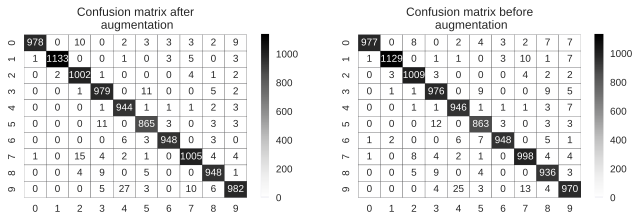

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(-1, 0)))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 3))
#plt.title(title, fontsize=16)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
plt.savefig("confusion_matrix_best_shiftxleft.pdf", bbox_inches='tight')

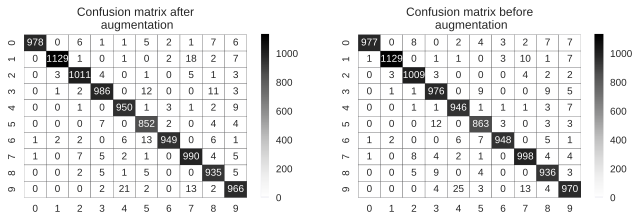

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(1, 0)))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 3))
#plt.title(title, fontsize=16)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
plt.savefig("confusion_matrix_best_shiftxright.pdf", bbox_inches='tight')

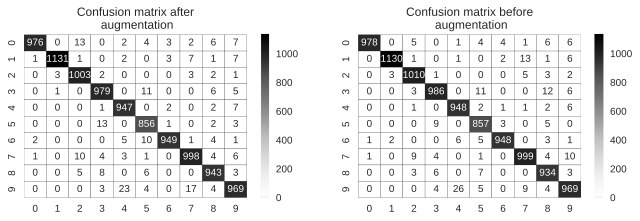

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(0, -1)))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
#plt.title(title, fontsize=16)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)

plt.savefig("confusion_matrix_best_shiftyleft.pdf", bbox_inches='tight')

5


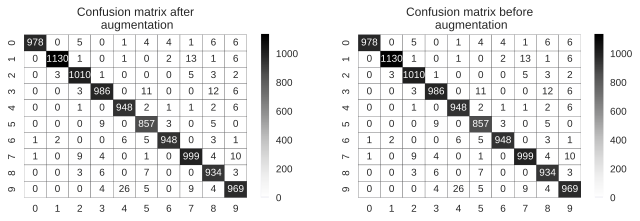

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(0, 1)))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
print(5)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

#plt.title(title, fontsize=16)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)

plt.savefig("confusion_matrix_best_shiftyright.pdf", bbox_inches='tight')

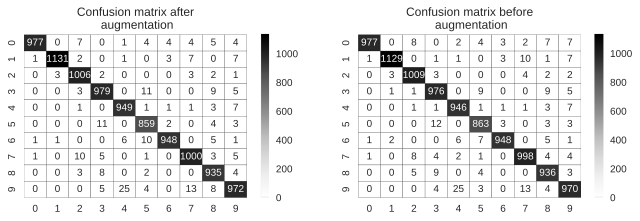

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.rotate,
                                           angle=-10, reshape=False))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))


class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)

plt.savefig("confusion_matrix_best_rotleft.pdf", bbox_inches='tight')

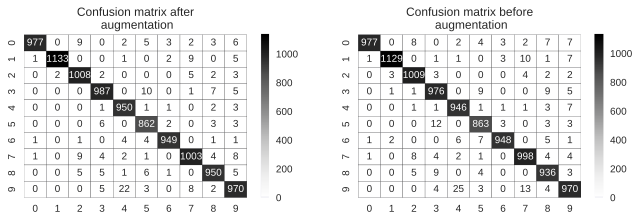

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.rotate,
                                           angle=10, reshape=False))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)

plt.savefig("confusion_matrix_best_rotright.pdf", bbox_inches='tight')

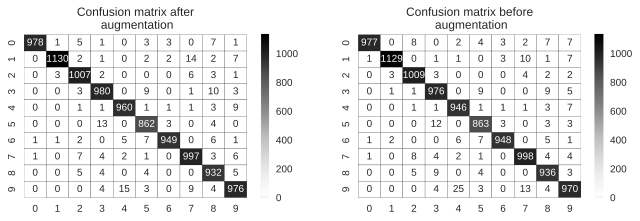

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=dilate,
                                           kernel=np.ones((2,2))
                                           ))),
                       np.hstack((y_train, y_train))
)


prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
plt.savefig("confusion_matrix_best_morph.pdf", bbox_inches='tight')

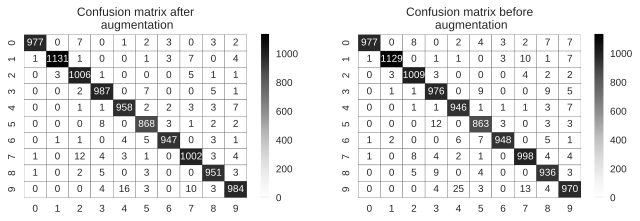

In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=GaussianBlur,
                                           ksize=(3,3), sigmaX=1.5))),
                       np.hstack((y_train, y_train)))
prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
plt.savefig("confusion_matrix_best_blur.pdf", bbox_inches='tight')

In [ ]:
'''
К сожалению для такой большой выборки уже не хватает памяти

numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, 
                       aug_sample(X_train,
                                  aug=GaussianBlur,
                                  ksize=(3,3), sigmaX=1.5),
                       aug_sample(X_train,
                                aug=dilate,
                                kernel=np.ones((2,2))),
                       aug_sample(X_train,
                                  aug=scipy.ndimage.rotate,
                                  angle=10, reshape=False),
                       
                       aug_sample(X_train,
                                  aug=scipy.ndimage.rotate,
                                  angle=-10, reshape=False),
                       aug_sample(X_train,
                                  aug=scipy.ndimage.shift,
                                  shift=(0, -1)),
                       aug_sample(X_train,
                                  aug=scipy.ndimage.shift,
                                  shift=(0, 1)),
                       aug_sample(X_train,
                                  aug=scipy.ndimage.shift,
                                  shift=(1, 0)),
                       aug_sample(X_train,
                                  aug=scipy.ndimage.shift,
                                  shift=(-1, 0)),
                       )),
                       np.tile(y_train, (1, 9)))

prediction = numb_cl.predict(X_test)
conf_m = confusion_matrix(prediction, y_test)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3))

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
plt.savefig("confusion_matrix_best_all.pdf", bbox_inches='tight')'''

6. Реализуйте описанный выше алгоритм, основанный на преобразовании объектов тестовой выборки. Проверьте то же самое множество параметров, что и в предыдущем пункте. Проанализируйте как изменилась
матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование. Качественно срав-
ните два подхода (5 и 6 пункты) между собой.  
#Замечание.
 В рамках данного эксперимента подразумевается обучение модели на оригинальном датасете,
преобразования объектов тестовой выборки, применение модели к преобразованным копиям изображения
из тестовой выборки и получение результата путем голосования среди преобразованных объектов.
Требования к

In [ ]:
from scipy import stats

In [68]:
def new_model(X_train, y_train, X_test,
              shift_xleft, shift_xright, shift_yleft, shift_yright,
              rotleft, rotright, devblur, morph, 
              morph_func,
              shift_func=scipy.ndimage.shift,
              rot_func=scipy.ndimage.rotate,
              devblur_func=GaussianBlur
              ):
    numb_cl = KNNClassifier(k=4, strategy='brute',
                            metric='cosine', weights=True)
    numb_cl.fit(X_train, y_train)
    all_predictions = np.empty((X_test.shape[0],9), dtype=str)

    transformations = [(devblur_func, devblur),
                       (None, {}),
                       (shift_func, shift_xleft),
                       (shift_func, shift_xright),
                       (shift_func, shift_yleft),
                       (shift_func, shift_yright),
                       (rot_func, rotleft),
                       (rot_func, rotright),
                       (morph_func, morph)]

    for idx_pred, (aug_func, kwargs) in enumerate(transformations):
        all_predictions[:, idx_pred] = numb_cl.predict(
            aug_sample(X_test, aug_func, **kwargs))
        idx_pred += 1

    return stats.mode(all_predictions, axis=1)[0].ravel()



In [ ]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)

best_shift_xleft = -1
best_shift_xright = 1
best_shift_yleft = -1
best_shift_yright = 1
best_rotleft = -5
best_rotright = 5
best_devblur = 0.5
best_morph = 'erode'

In [ ]:
%%time
shift_left = [-1, -2, -3]
max = 0
for shift_xleft in shift_left:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    if acc > max:
        max = acc
        best_shift_xleft = shift_xleft
print('best_shift_xleft', best_shift_xleft)

best_shift_xleft -2
CPU times: user 31min 41s, sys: 34.3 s, total: 32min 16s
Wall time: 19min 49s


In [ ]:
%%time
shift_left = [-1, -2, -3]
max=0
for shift_yleft in shift_left:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    if acc > max:
        max = acc
        best_shift_yleft = shift_yleft
print('best_shift_yleft', best_shift_yleft)

best_shift_yleft -3
CPU times: user 31min 31s, sys: 37.3 s, total: 32min 8s
Wall time: 19min 40s


In [ ]:
%%time
shift_right = [1, 2, 3]
max=0
for shift_xright in shift_right:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    print(acc)
    if acc > max:
        max = acc
        best_shift_xright = shift_xright
print('best_shift_xright', best_shift_xright)

0.9768
0.978
0.977
best_shift_xright 2
CPU times: user 31min 41s, sys: 39.7 s, total: 32min 21s
Wall time: 20min 13s


-2

In [ ]:
%%time
shift_right = [1, 2, 3]
max = 0
for shift_yright in shift_right:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    print(acc)
    if acc > max:
        max = acc
        best_shift_yright= shift_yright
print('best_shift_yright', best_shift_yright)

0.978
0.9778
0.9776
best_shift_yright 1
CPU times: user 31min 39s, sys: 38.3 s, total: 32min 17s
Wall time: 19min 47s


In [ ]:
%%time
rots = [-5, -10, -15]
max = 0
for rotleft in rots:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    if acc > max:
        max = acc
        best_rotleft = rotleft
print('best_rotleft', best_rotleft)


best_rotleft -10
CPU times: user 31min 26s, sys: 34.5 s, total: 32min
Wall time: 19min 33s


In [ ]:
%%time
rots = [5, 10, 15]
max = 0
for rotright in rots:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    if acc > max:
        max = acc
        best_rotright = rotright
print('best_rotright', best_rotright)

best_rotright 5
CPU times: user 31min 19s, sys: 35.1 s, total: 31min 54s
Wall time: 19min 47s


In [ ]:
%%time
devs = [0.5, 1.0, 1,5]
max = 0
for devblur in devs:
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=devblur),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
    acc = np.sum(pred == y_test) / len(y_test)
    print(acc)
    if acc > max:
        max = acc
        best_devblur = devblur
print('best_devblur', best_devblur)

0.9782
0.9783
0.9783
0.9781
best_devblur 1.0
CPU times: user 41min 54s, sys: 47.2 s, total: 42min 41s
Wall time: 26min 6s


In [ ]:
%%time
augs = [erode, dilate, morphologyEx, morphologyEx]
kernel = np.ones((2,2), np.uint8)
ops = [MORPH_OPEN, MORPH_CLOSE]
op = None
max = 0
best_morph = ''
for aug in augs:
    morph = None
    if aug in augs[:2]:
        morph = dict(kernel=np.ones((2,2)))
    else:
        op = ops.pop(0)
        morph = dict(kernel=np.ones((2,2)), op=op)
    
    pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(best_shift_xleft, 0)),
              shift_xright=dict(shift=(best_shift_xright, 0)),
              shift_yleft=dict(shift=(0, best_shift_yleft)),
              shift_yright=dict(shift=(0, best_shift_yright)),
              rotleft=dict(angle=best_rotleft, reshape=False),
              rotright=dict(angle=best_rotright, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=best_devblur),
              morph=morph,
              morph_func=aug)
    acc = np.sum(pred == y_test) / len(y_test)
    print(acc)
    if acc > max:
        max = acc
        if aug is erode:
            best_morph = 'erode'
        elif aug is dilate:
            best_morph = 'dilate'
        elif aug is morphologyEx:
            if op == MORPH_OPEN:
                best_morph = 'opening'
            else:
                best_morph = 'closing'
print('best_morph', best_morph)
    

0.9783
0.9769
0.9776
0.9776
best_morph erode
CPU times: user 42min 13s, sys: 45.4 s, total: 42min 58s
Wall time: 26min 20s


In [20]:
%%time
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(X_train, y_train)
prediction = numb_cl.predict(X_test)



CPU times: user 1min 12s, sys: 3.05 s, total: 1min 15s
Wall time: 46.3 s


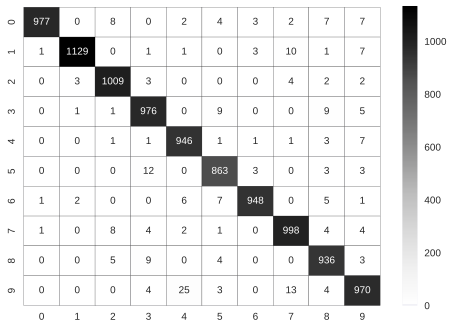

In [23]:
conf_main = confusion_matrix(prediction, y_test)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys")


In [37]:
figsize= (16, 4)

In [49]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(-1, 0)))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.shift,
                                   shift=(-2, 0)))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)



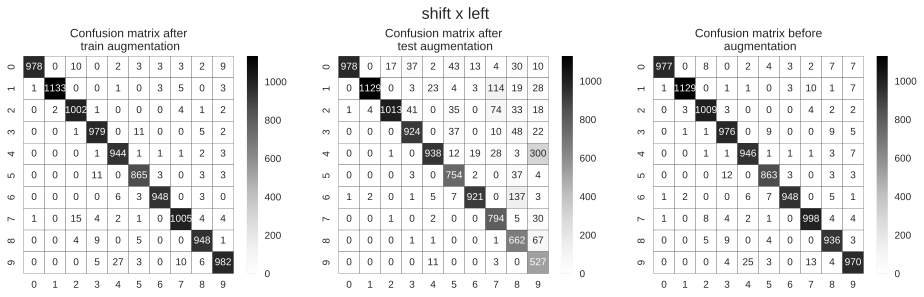

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
fig.suptitle("shift x left", fontsize=16, y=1.05)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

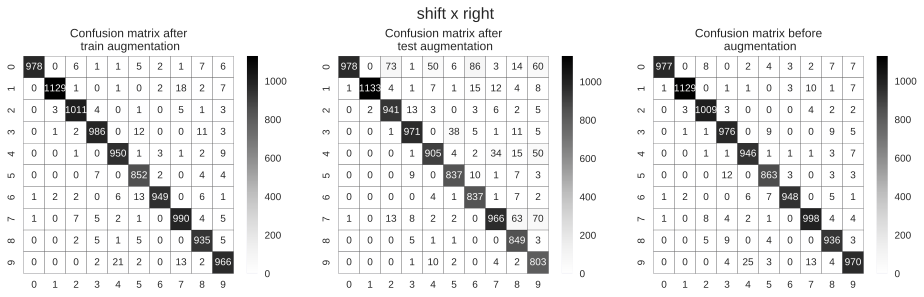

In [47]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(1, 0)))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.shift,
                                   shift=(2, 0)))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("shift x right", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

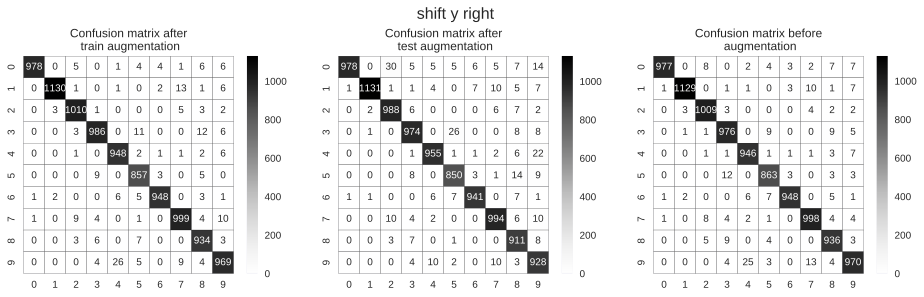

In [51]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(0, 1)))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.shift,
                                   shift=(0, 1)))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("shift y right", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

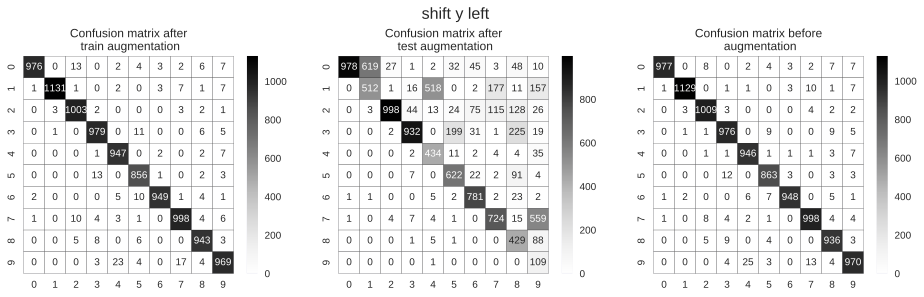

In [64]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.shift,
                                           shift=(0, -1)))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.shift,
                                   shift=(0, -3)))

prediction_aug_test = stats.mode(np.column_stack((pred2, pred1)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
fig.suptitle("shift y left", fontsize=16, y=1.05)
#plt.title(title, fontsize=16)

class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)
fig.savefig("test_sug_shiftyleft.pdf", bbox_inches='tight')

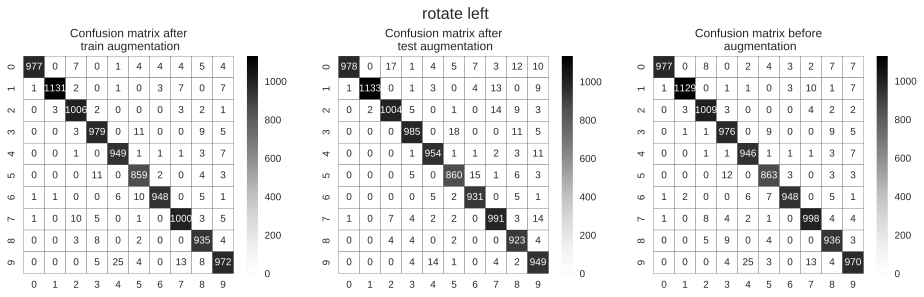

In [57]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.rotate,
                                           angle=-10, reshape=False))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.rotate,
                                   angle=-10, reshape=False))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("rotate left", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

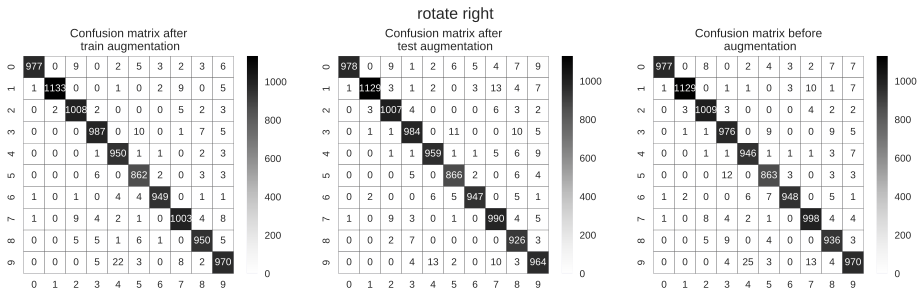

In [60]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=scipy.ndimage.rotate, 
                                           reshape=False,
                                           angle=10))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=scipy.ndimage.rotate,
                                   reshape=False,
                                   angle=5))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("rotate right", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

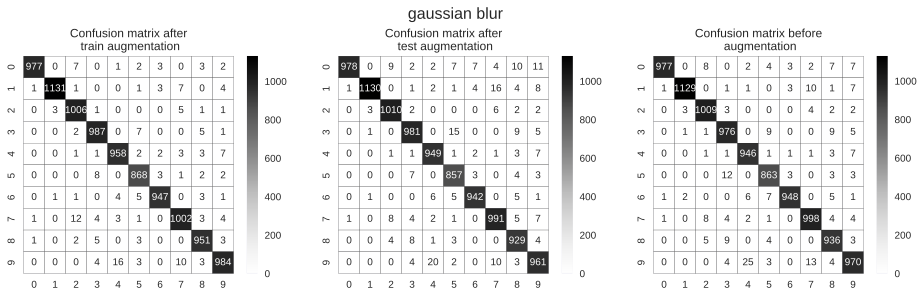

In [61]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=GaussianBlur,
                                           ksize=(3,3),
                                           sigmaX=1.5))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=GaussianBlur,
                                   ksize=(3, 3),
                                   sigmaX=1))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("gaussian blur", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

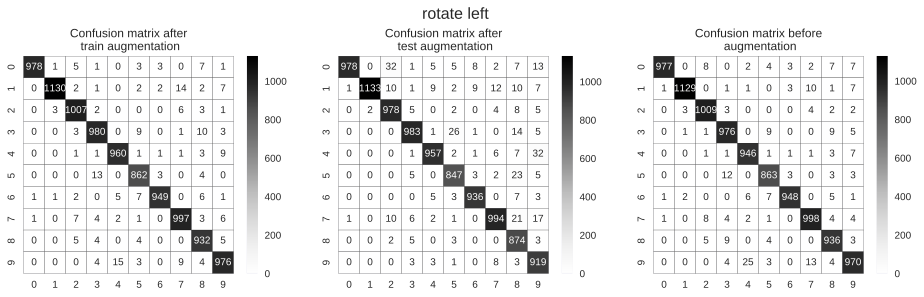

In [65]:
numb_cl = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
numb_cl.fit(np.vstack((X_train, aug_sample(X_train,
                                           aug=dilate,
                                           kernel=np.ones((2,2))
                                           ))),
                       np.hstack((y_train, y_train)))
prediction_aug_train = numb_cl.predict(X_test)

numb_cl.fit(X_train, y_train)
pred1 = numb_cl.predict(X_test)
pred2 = numb_cl.predict(aug_sample(X_test,
                                   aug=erode,
                                   kernel=np.ones((2, 2))))

prediction_aug_test = stats.mode(np.column_stack((pred1, pred2)),
                                 axis=1)[0].ravel()

conf_m1 = confusion_matrix(prediction_aug_train, y_test)
conf_m2 = confusion_matrix(prediction_aug_test, y_test)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figsize)
#plt.title(title, fontsize=16)
fig.suptitle("rotate left", fontsize=16, y=1.05)
class_names = np.arange(0, 10)
ax1.set_title("Confusion matrix after\n train augmentation")
ax2.set_title("Confusion matrix after\n test augmentation")
ax3.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax3)

In [67]:
100 * ((1 - 0.9783) / (1 - 0.9752) - 1)

-12.499999999999945

accuracy 0.9783


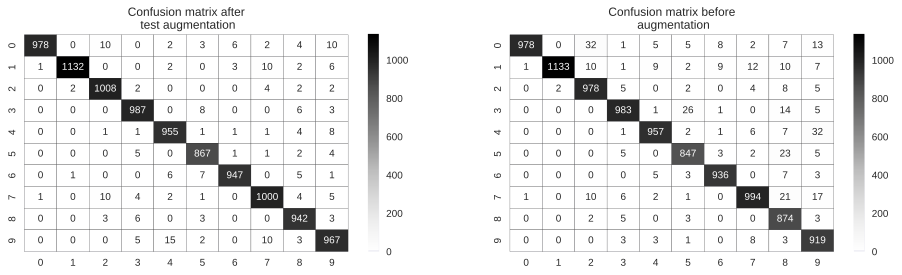

In [69]:
pred = new_model(X_train, y_train, X_test,
              shift_xleft=dict(shift=(-2, 0)),
              shift_xright=dict(shift=(2, 0)),
              shift_yleft=dict(shift=(0, -3)),
              shift_yright=dict(shift=(0, 1)),
              rotleft=dict(angle=-10, reshape=False),
              rotright=dict(angle=5, reshape=False),
              devblur=dict(ksize=(3, 3), sigmaX=1),
              morph=dict(kernel=np.ones((2,2))), 
              morph_func=erode)
print('accuracy', np.sum(pred == y_test) / len(pred))
conf_m1 = confusion_matrix(pred, y_test)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

class_names = np.arange(0, 10)

ax1.set_title("Confusion matrix after\n test augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_m2, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)

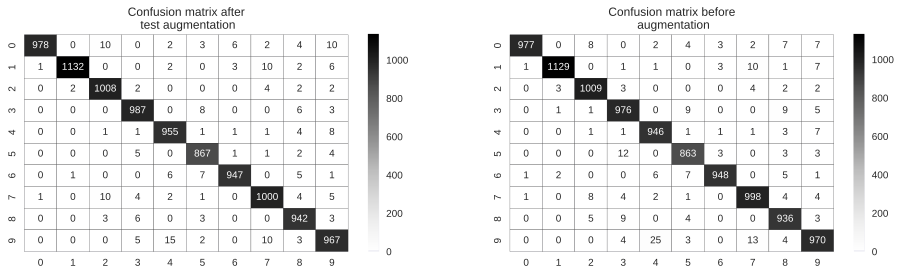

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

class_names = np.arange(0, 10)

ax1.set_title("Confusion matrix after\n test augmentation")
ax2.set_title("Confusion matrix before\n augmentation")
sns.heatmap(conf_m1, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax1)
sns.heatmap(conf_main, annot=True, fmt='d', linewidth=0.2, linecolor='black',
            cmap="Greys", ax=ax2)